# Automatic Data Labeling for Sentiment Analysis


Let us see how can we use automatic data labeling for building a sentiment classifier. This consists of four major steps:

1. **Loading Data**: train_labelled.txt, test_labelled.txt are the two files (from files/ folder) we will use here. The source of this data is mentioned in the slides. In the train_labelled.txt, I am only going to use the text, and discard the labels. I am going to keep the labels for test data, as we need something to evaluate our approach.

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, or third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a novel, theoretically-grounded [modeling approach](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

(Text is adapted from original Snorkel tutorial on spam classification)

### Task: Sentiment Classification

## 1. Loading Data

In [70]:
#reads train/test files
def read_data(filepath):
    texts = []
    labels = []
    for line in open(filepath):
        sentence, label = line.strip().split("\t")
        labels.append(int(label))
        texts.append(sentence)
    return texts, labels
    
train_texts, discard = read_data("../files/train_labelled.txt")
test_texts, test_labels = read_data("../files/test_labelled.txt")
discard = None #training labels are discarded. We won't use them

#convert to dataframe for ease of use later.
from pandas import DataFrame
df_train = DataFrame (train_texts,columns=['text'])
df_test = DataFrame(test_texts,columns=['text'])
df_test['label'] = test_labels


## 2. Writing Labeling Functions (LFs)

### a) Exploring the training set for initial ideas

We'll start by looking at 20 random data points from the `train` set to generate some ideas for LFs.

In [71]:
import random
random.sample(train_texts,10)

["I love Lane, but I've never seen her in a movie this lousy.  ",
 'The original Body and Soul (1947) is a masterpiece.  ',
 'The script is\x85was there a script?  ',
 'Our server was super nice and checked on us many times.',
 'Very disappointed and wondered how it could be in the Oscar shortlist.  ',
 "Clever and a real crowd-pleaser--this film still ranks among Mickey's best films even after 80 wonderful years.  ",
 'The plot simply rumbles on like a machine, desperately depending on the addition of new scenes.  ',
 'Tonight I had the Elk Filet special...and it sucked.',
 'This place deserves no stars.',
 "Once your food arrives it's meh."]

In [72]:
random.sample(train_texts,10)

['Alexander Nevsky is a great film.  ',
 'Why was this film made?  ',
 'It was not good.',
 'This is a great restaurant at the Mandalay Bay.',
 'It was also the right balance of war and love.  ',
 "It's a mediocre, miserable, hollow, laughable and predictable piece of garbage.  ",
 'There was a warm feeling with the service and I felt like their guest for a special treat.',
 'The only thing really worth watching was the scenery and the house, because it is beautiful.  ',
 'It is not just a cult... it is a cult CLASSIC.  ',
 'I thoroughly enjoyed it when Christopher Eccleston took control of the TARDIS and the continuation of the series.  ']

Using a list of positive/negative opinion words is a good starting point for writing the labeling functions. I will use the "Opinion Lexicon" from [here](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html) for this purpose. This contains a list of English positive and negative opinion words or sentiment words (around 6800 words in total). Details about the data are in the link. negative-words.txt, positive-words.txt in files/ contain these files. 

### b) Writing a few LFs

Labeling functions in Snorkel are created with the
[`@labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html).
The [decorator](https://realpython.com/primer-on-python-decorators/) can be applied to _any Python function_ that returns a label for a single data point.


In [73]:
#load positive and negative words lists.
def getsentimentwords(filepath):
    mylist = []
    for line in open(filepath, encoding="utf-8"):
        if line and not line.startswith(";"):
            mylist.append(line.strip())
    return mylist

positives = getsentimentwords("../resources/positive-words.txt")
negatives = getsentimentwords("../resources/negative-words.txt")

#load the vader lexicon:
def getvader(filepath):
    mydict = {}
    for line in open(filepath, encoding="utf-8"):
        temp = line.split("\t")
        if temp[0].isalpha():
            mydict[temp[0]] = float(temp[1])
    return mydict
myvader = getvader("../resources/vader_lexicon.txt")

In [74]:
print(len(positives))
print(len(negatives))
print(len(myvader))

2005
4783
7209


In [75]:
from snorkel.labeling import labeling_function
import re

POS=1
NEG=0
ABSTAIN=-1

#a simple labeling function checking if a sentence has positive words
@labeling_function()
def postive(x):
    poswords = 0
    temp = x.text.lower().split()
    for word in temp:
        if word in positives:
            poswords +=1
    if poswords > 0:
        return POS
    else:
        return ABSTAIN
    
#a simple labeling function checking if a sentence has negative words    
@labeling_function()
def negative(x):
    negwords = 0
    temp = x.text.lower().split()
    for word in temp:
        if word in negatives:
            negwords +=1
    if negwords > 0:
        return NEG
    else:
        return ABSTAIN

#Look up the word's mean-sentiment rating in Vader Lexicon
#https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt
#if overall score for a sentence is positive, return POS, else, NEG. if 0, return ABSTAIN.
@labeling_function()
def vaderlex(x):
    temp = x.text.lower().split()
    sentiment = 0
    for word in temp:
        if word in myvader:
            sentiment += myvader[word]
    if sentiment > 0:
        return POS
    elif sentiment <0:
        return NEG
    else:
        return ABSTAIN
    
#More function ideas: https://medium.com/@datamonsters/sentiment-analysis-tools-overview-part-1-positive-and-negative-words-databases-ae35431a470c

To apply one or more LFs that we've written to a collection of data points, we use an
[`LFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFApplier.html).
Because our data points are represented with a Pandas DataFrame in this tutorial, we use the
[`PandasLFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html).
Correspondingly, a single data point `x` that's passed into our LFs will be a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html).

It's important to note that these LFs will work for any object with an attribute named `text`, not just Pandas objects.
Snorkel has several other appliers for different data point collection types which you can browse in the [API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

The output of the `apply(...)` method is a ***label matrix***, a fundamental concept in Snorkel.
It's a NumPy array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the `j`th labeling function output for the `i`th data point.
We'll create a label matrix for the `train` set.

In [76]:
from snorkel.labeling import PandasLFApplier
from pandas import DataFrame

lfs = [postive,negative,vaderlex]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

100%|██████████| 2000/2000 [00:01<00:00, 1243.40it/s]


### c) Evaluate performance on training set

Lots of statistics about labeling functions &mdash; like coverage &mdash; are useful when building any Snorkel application.
So Snorkel provides tooling for common LF analyses using the
[`LFAnalysis` utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html).
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of unique labels this LF outputs (excluding abstains)
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for data points where it abstained.
We calculate these statistics only over those data points where the LF output a label.
**Note that in our current setup, we can't compute these statistics because we don't have any ground-truth labels (other than in the test set, which we cannot look at). Not to worry—Snorkel's `LabelModel` will estimate them without needing any ground-truth labels in the next step!**

In [77]:
from snorkel.labeling import LFAnalysis

lfs = [postive,negative, vaderlex]

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
postive,0,[1],0.4695,0.4395,0.1055
negative,1,[0],0.2725,0.2360,0.1165
vaderlex,2,"[0, 1]",0.6320,0.5725,0.1190


## 4. Combining Labeling Function Outputs with the Label Model

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
One of the key goals of Snorkel is _not_ to replace the effort, creativity, and subject matter expertise required to come up with these labeling functions, but rather to make it faster to write them, since **in Snorkel the labeling functions are assumed to be noisy, i.e. innaccurate, overlapping, etc.**
Said another way: the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

Once we perform some LFs analysis and finalize our list,  we can now apply these once again with `LFApplier` to get the label matrices.
The Pandas format provides an easy interface that many practitioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

In [78]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

100%|██████████| 1000/1000 [00:00<00:00, 1440.19it/s]


In [79]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
postive,0,[1],0.4695,0.4395,0.1055
negative,1,[0],0.2725,0.2360,0.1165
vaderlex,2,"[0, 1]",0.6320,0.5725,0.1190


We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well.
We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

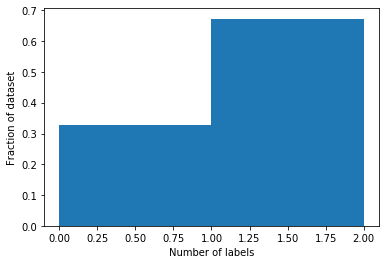

In [80]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have more than 1 label from LFs.
Fortunately, the labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.baselines.MajorityLabelVoter.html#snorkel.labeling.model.baselines.MajorityLabelVoter).

However, as we can see from the summary statistics of our LFs in the previous section, they have varying properties and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.

In [81]:
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)


Y_test = df_test.label.values

majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   72.1%
Label Model Accuracy:     71.7%


The majority vote model or more sophisticated `LabelModel` could in principle be used directly as a classifier if the outputs of our labeling functions were made available at test time.
However, these models (i.e. these re-weighted combinations of our labeling function's votes) will abstain on the data points that our labeling functions don't cover (and additionally, may require slow or unavailable features to execute at test time).
In the next section, we will instead use the outputs of the `LabelModel` as training labels to train a discriminative classifier **which can generalize beyond the labeling function outputs** to see if we can improve performance further.
This classifier will also only need the text of the comment to make predictions, making it much more suitable for inference over unseen comments.
For more information on the properties of the label model, see the [Snorkel documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.model.label_model.LabelModel.html#snorkel.labeling.model.label_model.LabelModel).

Let's briefly confirm that the labels the `LabelModel` produces are indeed probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

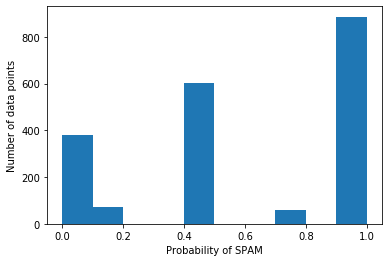

In [82]:


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, POS])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [83]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

print(df_train.shape)
print(df_train_filtered.shape)

(2000, 1)
(1407, 1)


## 5. Training a Classifier

In this final section of the tutorial, we'll use the probabilistic training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost.**
In this tutorial, we use the well-known library [Scikit-Learn](https://scikit-learn.org).
**Note that typically, Snorkel is used (and really shines!) with much more complex, training data-hungry models, but we will use Logistic Regression here for simplicity of exposition.**

### Featurization

For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

print(X_train.shape)
print(X_test.shape)

(1407, 61087)
(1000, 61087)


### Scikit-Learn Classifier

As we saw in Section 4, the `LabelModel` outputs probabilistic (float) labels.
If the classifier we are training accepts target labels as floats, we can train on these labels directly (see describe the properties of this type of "noise-aware" loss in our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).

If we want to use a library or model that doesn't accept probabilistic labels (such as Scikit-Learn), we can instead replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
We do note, however, that this transformation is lossy, as we no longer have values for our confidence in each label.

In [85]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

We then use these labels to train a classifier as usual.

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

Y_test = df_test.label.values

for classifier in [LogisticRegression(C=1e3, solver="liblinear"), LinearSVC()]:
    classifier.fit(X=X_train, y=preds_train_filtered)
    print("Performance for ", type(classifier).__name__), 
    print(f"Test Accuracy: {classifier.score(X=X_test, y=test_labels) * 100:.1f}%")
    #print(preds_train_filtered)
    #print(test_labels)


Performance for  LogisticRegression
Test Accuracy: 61.2%
Performance for  LinearSVC
Test Accuracy: 62.0%


**We observe an additional boost in accuracy over the `LabelModel` by multiple points! This is in part because the discriminative model generalizes beyond the labeling function's labels and makes good predictions on all data points, not just the ones covered by labeling functions.
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

In [91]:
#Collect the new dataset and save it. 
auto_labeled_data = DataFrame(
    {'text': df_train_filtered.text.tolist(),
     'sentiment': preds_train_filtered,
    })
auto_labeled_data.to_csv("../files/snorkellabeled_train.csv", sep="\t", index=False, header=False)

## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine the outputs of our LFs into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.